In [1]:
import cv2
import random
import os
import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
import pandas as pd
import random
import shutil

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
!unzip /content/training_images.zip

Archive:  /content/training_images.zip
  inflating: training_images/vid_4_1000.jpg  
  inflating: training_images/vid_4_10000.jpg  
  inflating: training_images/vid_4_10020.jpg  
  inflating: training_images/vid_4_10040.jpg  
  inflating: training_images/vid_4_10060.jpg  
  inflating: training_images/vid_4_10080.jpg  
  inflating: training_images/vid_4_10100.jpg  
  inflating: training_images/vid_4_10120.jpg  
  inflating: training_images/vid_4_10140.jpg  
  inflating: training_images/vid_4_10160.jpg  
  inflating: training_images/vid_4_10180.jpg  
  inflating: training_images/vid_4_1020.jpg  
  inflating: training_images/vid_4_10200.jpg  
  inflating: training_images/vid_4_10220.jpg  
  inflating: training_images/vid_4_10240.jpg  
  inflating: training_images/vid_4_10260.jpg  
  inflating: training_images/vid_4_10280.jpg  
  inflating: training_images/vid_4_10300.jpg  
  inflating: training_images/vid_4_10320.jpg  
  inflating: training_images/vid_4_10340.jpg  
  inflating: training_i

In [4]:
data_path = '/content/training_images'
targets_path = '/content/train_solution_bounding_boxes (1).csv'

In [5]:
data = []
targets = []
filenames = []

In [6]:
df = pd.read_csv(targets_path)

for _, col in df.iterrows():

    # Get H, W
    img_path = os.path.join(data_path, col['image'])
    img = cv2.imread(img_path)
    (h, w) = img.shape[:2]

    # scale the bounding box coordinates
    startX = float(col['xmin']) / w
    startY = float(col['ymin']) / h
    endX = float(col['xmax']) / w
    endY = float(col['ymax']) / h

    # load the image and preprocess it
    image = load_img(img_path, target_size=(224, 224)) # image = cv2.resize(img, (224,224))
    image = img_to_array(image) # image = np.array(image)

    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(col['image'])

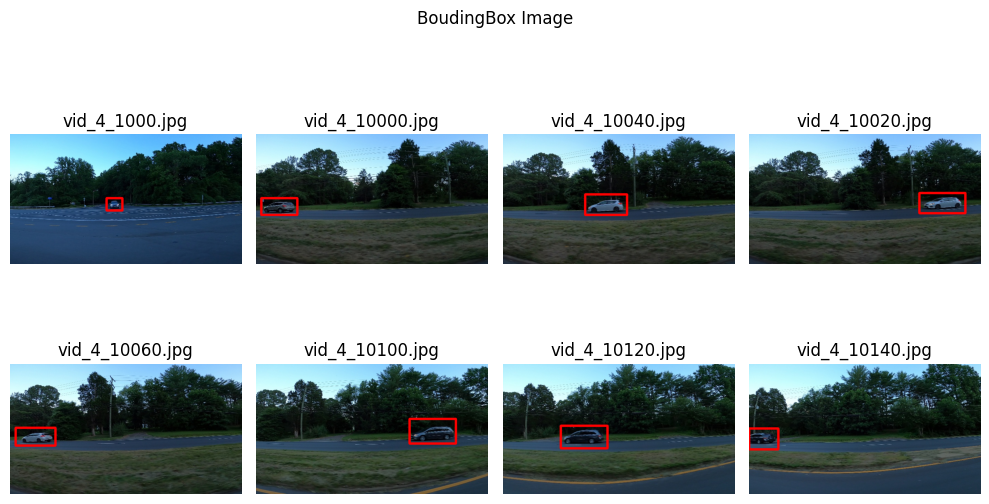

In [7]:
fig, axes = plt.subplots(2,4, figsize=(10,6))
fig.suptitle('BoudingBox Image')

for x, (name, target) in enumerate(zip(filenames[:8], targets[:8])):
    file_path = os.path.join(data_path, name)
    img = cv2.imread(file_path)
    img_draw = img.copy()
    (h, w) = img.shape[:2]

    startX = int(target[0] * w)
    startY = int(target[1] * h)
    endX = int(target[2] * w)
    endY = int(target[3] * h)

    cv2.rectangle(img_draw, (startX, startY), (endX, endY), (0, 0, 255), 5)

    axes[x // 4, x % 4].set_title(f'{name}')
    axes[x // 4, x % 4].imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    axes[x // 4, x % 4].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

In [8]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [9]:
split = train_test_split(data, targets, filenames, test_size=0.10,random_state=42)

In [10]:
(trainImages, valImages) = split[:2]
(trainTargets, valTargets) = split[2:4]
(trainFilenames, valFilenames) = split[4:]

In [11]:
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

In [13]:
model = Model(inputs=vgg.input, outputs=bboxHead)

In [14]:
opt = Adam(lr=0.001)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
history = model.fit(trainImages, trainTargets, validation_data=(valImages, valTargets),
                    batch_size=32, epochs=25, verbose=1)

model.save('/content/my_model.h5')

Epoch 1/25
16/16 [==============================] - 330s 21s/step - loss: 0.0756 - val_loss: 0.0755
Epoch 2/25
16/16 [==============================] - 338s 21s/step - loss: 0.0440 - val_loss: 0.0393
Epoch 3/25
16/16 [==============================] - 330s 21s/step - loss: 0.0397 - val_loss: 0.0486
Epoch 4/25
16/16 [==============================] - 337s 21s/step - loss: 0.0324 - val_loss: 0.0563
Epoch 5/25
16/16 [==============================] - 338s 21s/step - loss: 0.0289 - val_loss: 0.0429
Epoch 6/25
16/16 [==============================] - 329s 21s/step - loss: 0.0300 - val_loss: 0.0441
Epoch 7/25
16/16 [==============================] - 336s 21s/step - loss: 0.0293 - val_loss: 0.0485
Epoch 8/25
16/16 [==============================] - 333s 21s/step - loss: 0.0250 - val_loss: 0.0614
Epoch 9/25
16/16 [==============================] - 330s 21s/step - loss: 0.0264 - val_loss: 0.0493
Epoch 10/25
16/16 [==============================] - 337s 21s/step - loss: 0.0267 - val_loss: 0.0492

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
def IoU(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calculate Intersection Area
    inter_area = (y2_inter - y1_inter) * (x2_inter - x1_inter)

    # Calculate Uninon Area:
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area

    IoU = inter_area/union_area

    return abs(IoU)

In [18]:
acc_list = []

for _, col in df.iterrows():
    img_path = os.path.join(data_path, col['image'])
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)[0]
    box1 = preds

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    (h, w) = img.shape[:2]

    # scale the bounding box coordinates
    startX = float(col['xmin']) / w
    startY = float(col['ymin']) / h
    endX = float(col['xmax']) / w
    endY = float(col['ymax']) / h

    box2 = [startX, startY, endX, endY]

    acc_list.append(IoU(box1, box2))

1/1 [==============================] - 1s 563ms/step


In [19]:
!unzip /content/testing_images.zip

Archive:  /content/testing_images.zip
  inflating: testing_images/vid_5_25100.jpg  
  inflating: testing_images/vid_5_25120.jpg  
  inflating: testing_images/vid_5_25140.jpg  
  inflating: testing_images/vid_5_25160.jpg  
  inflating: testing_images/vid_5_25180.jpg  
  inflating: testing_images/vid_5_25200.jpg  
  inflating: testing_images/vid_5_25220.jpg  
  inflating: testing_images/vid_5_25240.jpg  
  inflating: testing_images/vid_5_25260.jpg  
  inflating: testing_images/vid_5_26320.jpg  
  inflating: testing_images/vid_5_26400.jpg  
  inflating: testing_images/vid_5_26420.jpg  
  inflating: testing_images/vid_5_26560.jpg  
  inflating: testing_images/vid_5_26580.jpg  
  inflating: testing_images/vid_5_26600.jpg  
  inflating: testing_images/vid_5_26620.jpg  
  inflating: testing_images/vid_5_26640.jpg  
  inflating: testing_images/vid_5_26660.jpg  
  inflating: testing_images/vid_5_26680.jpg  
  inflating: testing_images/vid_5_26700.jpg  
  inflating: testing_images/vid_5_26720.jp

In [20]:
from tensorflow.keras.models import load_model
test_path = '/content/testing_images'
model = load_model('/content/my_model.h5')

1/1 [==============================] - 1s 719ms/step


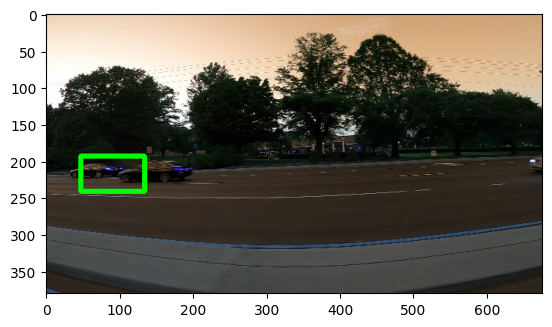

1/1 [==============================] - 1s 588ms/step


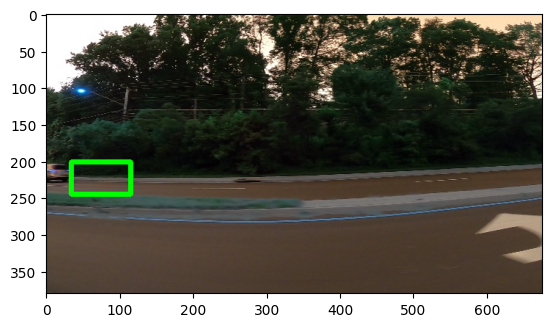

1/1 [==============================] - 1s 595ms/step


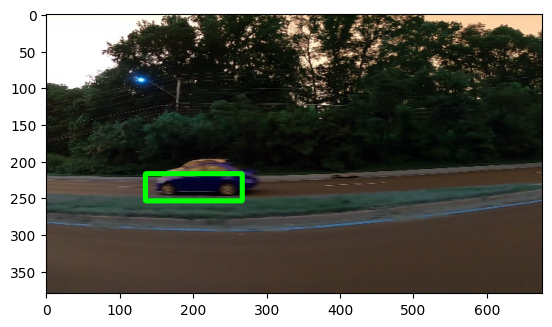

1/1 [==============================] - 1s 610ms/step


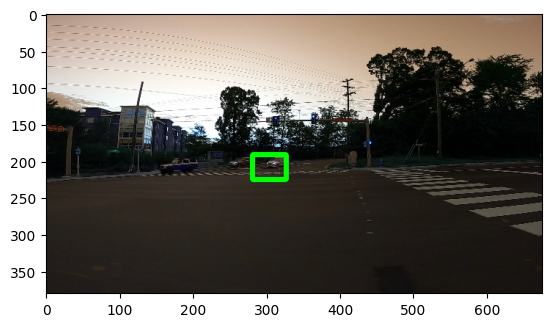

1/1 [==============================] - 1s 579ms/step


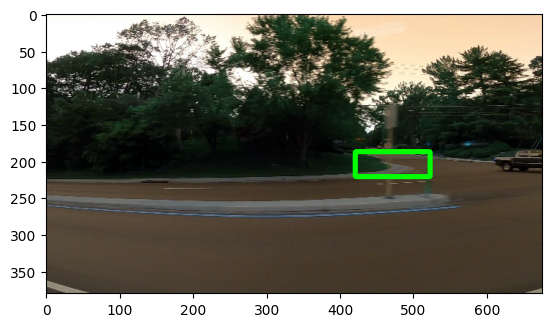

1/1 [==============================] - 1s 599ms/step


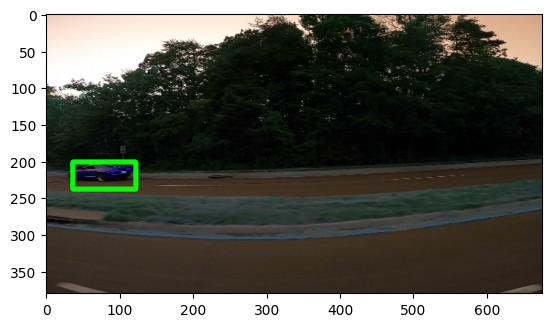

1/1 [==============================] - 1s 693ms/step


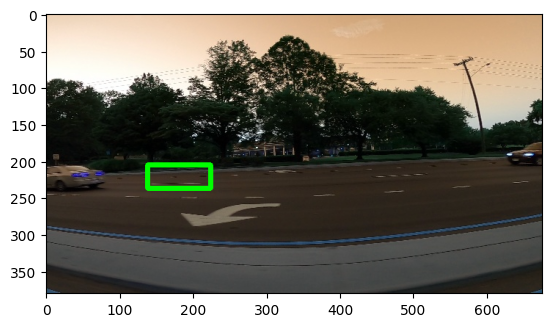

1/1 [==============================] - 1s 1s/step


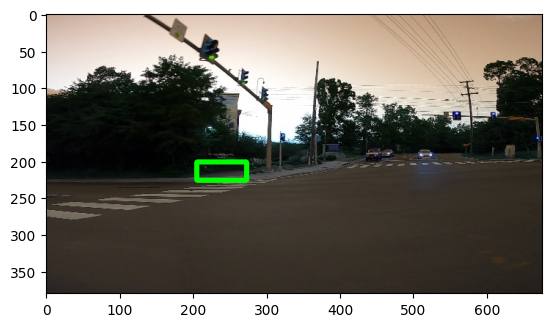

1/1 [==============================] - 1s 942ms/step


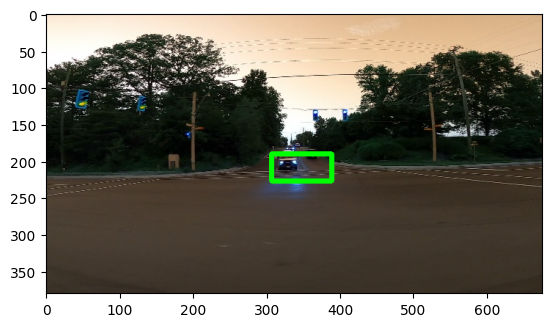

1/1 [==============================] - 1s 593ms/step


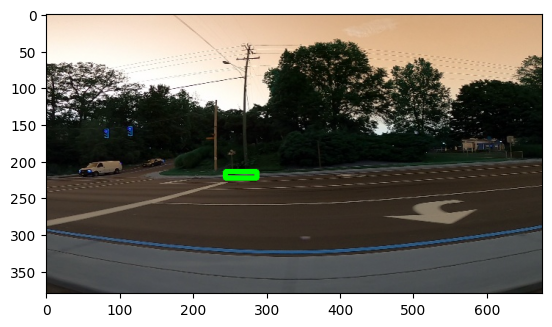

In [21]:
NUM_FILE = 10 # get 5 files to predict

for img in random.sample(os.listdir(test_path), NUM_FILE):
    img_path = os.path.join(test_path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds

    img = cv2.imread(img_path)
    (h, w) = img.shape[:2]

    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    img_draw = img.copy()
    cv2.rectangle(img_draw, (startX, startY), (endX, endY), (0, 255, 0), 5)
    plt.imshow(img_draw)

    plt.show()